In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import pickle

In [3]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

with open('imglist.pt', 'rb') as f:
    images = pickle.load(f)

In [4]:
class AffonsoNet(nn.Module):

    def __init__(self,dropout = 0.5):
        super(AffonsoNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=10)
        self.conv2 = nn.Conv2d(20, 25, kernel_size=10)
        self.fc1 = nn.Linear(14875,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 4)
        self.mp = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(x)
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv1(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv2(x)))
        x = self.mp(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return torch.log_softmax(x,1)


In [ ]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,data[i],axis=0)
                l += labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

In [ ]:
avedloss, avedacc, avevloss, avevacc = 0,0,0,0
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

batch_size = 128
disable = False
epochs = 50
dropout = 0.5
weight_decay = 0.5

for i in range(5):
    model = AffonsoNet(dropout=dropout).cuda()
    optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
    #amp_handle.wrap_optimizer(optimizer)
    criterion = nn.CrossEntropyLoss()
    #amp_handle = amp.init()
    dlosscurve = []
    dacccurve = []
    vlosscurve = []
    vacccurve = []
    print("Fold %d" % (i + 1))
    my_data.setTest(i)
    my_test.setTest(i)
    
    my_loader = DataLoader(my_data, batch_size=batch_size,
                            shuffle=True)
    my_test_loader = DataLoader(my_test, batch_size=batch_size,
                            shuffle=True)
    for j in range(epochs):
        dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
        vloss, vacc = test(model,criterion,my_test_loader,disable)
        dlosscurve.append(dloss)
        dacccurve.append(dacc)
        vlosscurve.append(vloss)
        vacccurve.append(vacc)
        if j % 1 == 0:
            print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
    df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
    df.plot.line()
    avedloss += dloss
    avedacc += dacc
    avevloss += vloss
    avevacc += vacc
avedloss /= 5
avedacc /= 5
avevloss /= 5
avevacc /= 5
print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  4.89it/s]


Epoch Train Loss: 1.044304  Epoch Train Accuracy: 51.160714


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.77it/s]


Epoch Train Loss: 0.720452  Epoch Train Accuracy: 51.612103


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.77it/s]


Epoch Train Loss: 0.704657  Epoch Train Accuracy: 53.854167


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.81it/s]


Epoch Train Loss: 0.720874  Epoch Train Accuracy: 56.502976


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.60it/s]


Epoch Train Loss: 0.707557  Epoch Train Accuracy: 52.668651


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.71it/s]


Epoch Train Loss: 0.684279  Epoch Train Accuracy: 56.780754


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.76it/s]


Epoch Train Loss: 0.666228  Epoch Train Accuracy: 59.593254


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.04it/s]


Epoch Train Loss: 0.667575  Epoch Train Accuracy: 61.001984


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.68it/s]


Epoch Train Loss: 0.690758  Epoch Train Accuracy: 57.301587


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.97it/s]


Epoch Train Loss: 0.652751  Epoch Train Accuracy: 61.671627


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.85it/s]


Epoch Train Loss: 0.638183  Epoch Train Accuracy: 64.945437


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.96it/s]


Epoch Train Loss: 0.618043  Epoch Train Accuracy: 68.100198


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.88it/s]


Epoch Train Loss: 0.615916  Epoch Train Accuracy: 66.577381


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.85it/s]


Epoch Train Loss: 0.606126  Epoch Train Accuracy: 65.436508


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.77it/s]


Epoch Train Loss: 0.588901  Epoch Train Accuracy: 69.340278


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.58it/s]


Epoch Train Loss: 0.591148  Epoch Train Accuracy: 69.082341


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.86it/s]


Epoch Train Loss: 0.586569  Epoch Train Accuracy: 68.516865


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.65it/s]


Epoch Train Loss: 0.579265  Epoch Train Accuracy: 70.967262


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.45it/s]


Epoch Train Loss: 0.563597  Epoch Train Accuracy: 70.436508


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.81it/s]


Epoch Train Loss: 0.598980  Epoch Train Accuracy: 68.095238


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.84it/s]


Epoch Train Loss: 0.557027  Epoch Train Accuracy: 73.164683


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.90it/s]


Epoch Train Loss: 0.545382  Epoch Train Accuracy: 72.415675


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.89it/s]


Epoch Train Loss: 0.560033  Epoch Train Accuracy: 71.855159


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.74it/s]


Epoch Train Loss: 0.540845  Epoch Train Accuracy: 72.827381


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.80it/s]


Epoch Train Loss: 0.522992  Epoch Train Accuracy: 73.893849


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.89it/s]


Epoch Train Loss: 0.512535  Epoch Train Accuracy: 74.965278


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.52it/s]


Epoch Train Loss: 0.502368  Epoch Train Accuracy: 75.178571


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.98it/s]


Epoch Train Loss: 0.511887  Epoch Train Accuracy: 75.119048


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.85it/s]


Epoch Train Loss: 0.507061  Epoch Train Accuracy: 75.753968


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch Train Loss: 0.479902  Epoch Train Accuracy: 76.860119


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.68it/s]


Epoch Train Loss: 0.499085  Epoch Train Accuracy: 76.433532


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.95it/s]


Epoch Train Loss: 0.476147  Epoch Train Accuracy: 78.249008


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.97it/s]


Epoch Train Loss: 0.454782  Epoch Train Accuracy: 78.308532


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch Train Loss: 0.425712  Epoch Train Accuracy: 78.730159


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.81it/s]


Epoch Train Loss: 0.448182  Epoch Train Accuracy: 79.345238


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.04it/s]


Epoch Train Loss: 0.411843  Epoch Train Accuracy: 79.399802


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.86it/s]


Epoch Train Loss: 0.417977  Epoch Train Accuracy: 81.230159


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.06it/s]


Epoch Train Loss: 0.416978  Epoch Train Accuracy: 80.853175


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.96it/s]


Epoch Train Loss: 0.415073  Epoch Train Accuracy: 80.704365


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch Train Loss: 0.393354  Epoch Train Accuracy: 82.167659


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.96it/s]


Epoch Train Loss: 0.400282  Epoch Train Accuracy: 80.704365


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.90it/s]


Epoch Train Loss: 0.388755  Epoch Train Accuracy: 83.095238


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.88it/s]


Epoch Train Loss: 0.414426  Epoch Train Accuracy: 80.128968


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.70it/s]


Epoch Train Loss: 0.379205  Epoch Train Accuracy: 83.576389


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.76it/s]


Epoch Train Loss: 0.371139  Epoch Train Accuracy: 81.542659


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.90it/s]


Epoch Train Loss: 0.318760  Epoch Train Accuracy: 85.302579


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.79it/s]


Epoch Train Loss: 0.359838  Epoch Train Accuracy: 85.252976


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.97it/s]


Epoch Train Loss: 0.367218  Epoch Train Accuracy: 84.394841


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.00it/s]


Epoch Train Loss: 0.353492  Epoch Train Accuracy: 83.938492


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.00it/s]


Epoch Train Loss: 0.319679  Epoch Train Accuracy: 87.073413
Average Train Loss: 0.319679
Average Train Accuracy: 0.870734


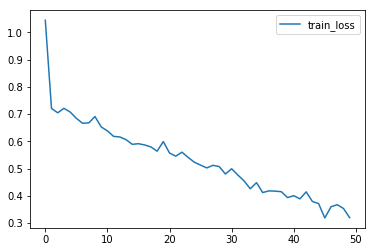

In [7]:
my_val = AutoUXDataset(dataVal,labelsVal,False,True)
disable = False
my_val_loader = DataLoader(my_val, batch_size=batch_size,shuffle=True)
vloss, vacc = test(model,criterion,my_val_loader,disable)
print("Validation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(vloss,vacc))

In [8]:
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_val,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.73it/s]


[1.71839198e-01 5.17634127e-01 1.22479390e-01 8.78567314e-02
 4.31184186e-02 2.00700882e-01 3.74149727e-01 7.61689838e-01
 7.83693147e-02 1.33537283e-01 2.51179068e-01 5.85105109e-01
 7.02020147e-02 6.11473151e-01 8.41396848e-02 2.12065079e-01
 3.77483379e-01 1.72916498e-01 2.01270108e-01 2.43487257e-02
 3.29804224e-02 4.78170333e-03 2.03123213e-01 1.32029081e-01
 2.75389863e-02 1.90998179e-02 3.74909882e-02 2.41010250e-01
 2.14200445e-02 3.32756615e-01 9.43440203e-01 1.56243298e-01
 7.03784335e-01 8.17585883e-01 7.47308161e-01 9.77633251e-01
 9.52521693e-01 8.79545258e-01 9.60129065e-01 2.41852579e-01
 6.35930926e-01 9.77882685e-01 7.60386333e-01 9.89962746e-01
 9.89736659e-01 3.61857682e-01 1.94922001e-01 9.77493876e-01
 8.78679204e-01 1.97080829e-01 2.01812654e-01 7.50462925e-01
 9.34793136e-01 9.74889492e-01 9.75489815e-01 6.11676995e-01
 6.55224460e-01 4.32137047e-01 9.36418839e-01 7.81349697e-01
 6.88399360e-01 7.02781970e-01 1.48826621e-01 5.91692836e-01
 1.28716465e-01 1.699252

In [9]:
false_pos = []
false_neg = []

for i in range(0,len(answers)):
#     print("{} Predicted: {} \t Actual: {}".format(images[i],int(preds[i]),int(labels[i])))
    if int(labels[i]) < int(preds[i]):
        false_pos.append(images[i])
    elif int(labels[i]) > int(preds[i]):
        false_neg.append(images[i])
print("False Positives:")
for x in false_pos:
    print(x)
print("\nFalse Negatives:")
for x in false_neg:
    print(x)

False Positives:
1-800-flowers - 2
1-800-flowers - 8
1-800-flowers - 12
1-800-flowers - 14
American Apparel - 1
American Apparel - 7
American Apparel - 9
Blinkee - 1
Blinkee - 8
Costco - 2
Costco - 13
CVS - 14
Fanatics - 4
Fanatics - 5
Fanatics - 8
Fanatics - 15
Footlocker - 3
Free City Supershop - 1
H & M - 17
Ikea - 13
Mercia Tourist Board - 6
Nordstrom - 12
Paradise With A View - 1
Rakuten - 16
Rakuten - 18
Urban Outfitters - 2
Urban Outfitters - 7

False Negatives:
Alibaba - 2
Alibaba - 10
Amazon - 1
Amazon - 2
Amazon - 5
Amazon - 6
Amazon - 13
Amazon - 18
Azteca Soccer - 6
BestBuy - 5
BestBuy - 7
BestBuy - 8
BestBuy - 9
BestBuy - 11
BestBuy - 13
BestBuy - 14
BestBuy - 18
BigCommerce - 3
BigCommerce - 7
BigCommerce - 17
BigCommerce - 18
Bliss - 11
Bliss - 12
BonBonBon - 1
BonBonBon - 5
BonBonBon - 6
BonBonBon - 9
BonBonBon - 10
BonBonBon - 11
BonBonBon - 15
BonBonBon - 16
BonBonBon - 17
BonBonBon - 19
CruiseMaster - 5
CruiseMaster - 11
CruiseMaster - 14
Custom Barres - 2
Custom Bar

In [9]:
with open('AffonsoNetoutprobs.pt', 'wb') as f:
    pickle.dump(answers, f)

Confusion matrix, without normalization
[[195 270]
 [215 258]]
Normalized confusion matrix
[[0.42 0.58]
 [0.45 0.55]]


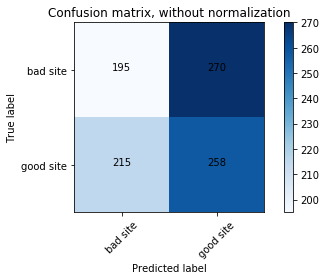

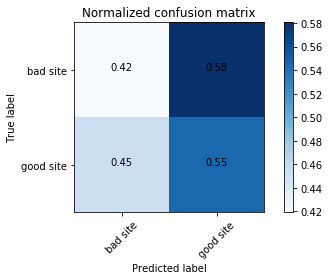

Accuracy: 0.4829


In [10]:
from sklearn.metrics import *
import itertools
import pickle
with open('AffonsoNetout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))